<a href="https://colab.research.google.com/github/tomo-makes/colab-notebooks/blob/master/Audio_Source_Separation_with_Wave_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Source Separation with Wave-U-Net

- ボーカル入りの音楽ファイルを与え、学習済みの深層学習モデルを使って、ボーカルと楽器演奏を分離する
- [Wave-U-Net論文](https://arxiv.org/abs/1806.03185)の著者実装をColaboratoryで実行する

## Wave-U-Netをセットアップする

In [1]:
!git clone https://github.com/f90/Wave-U-Net.git
%cd Wave-U-Net/

Cloning into 'Wave-U-Net'...
remote: Enumerating objects: 250, done.
remote: Total 250 (delta 0), reused 0 (delta 0), pack-reused 250
Receiving objects: 100% (250/250), 7.26 MiB | 9.25 MiB/s, done.
Resolving deltas: 100% (133/133), done.
/content/Wave-U-Net


### 依存Pythonライブラリを導入

Colaboratoryデフォルトで導入されているものは省く

In [2]:
!pip install sacred soundfile lxml musdb museval protobuf

     |████████████████████████████████| 102kB 7.0MB/s 
     |████████████████████████████████| 92kB 18.1MB/s 
     |████████████████████████████████| 71kB 21.0MB/s 
     |████████████████████████████████| 512kB 42.1MB/s 
     |████████████████████████████████| 81kB 21.9MB/s 
     |████████████████████████████████| 10.5MB 35.1MB/s 
     |████████████████████████████████| 235kB 42.1MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-5.0.0-cp36-none-any.whl size=18685 sha256=da1b6d7580cb297eead86deb5b7560ab8d876bd9789d9fb50554546cb58eca1d
  Stored in directory: /root/.cache/pip/wheels/01/7e/a9/b982d0fea22b7e4ae5619de949570cde5ad55420cec16e86a5
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=1688fb6f55945cbd327f2bf7dfbfdbb5abf6cc9945588da7ff2c1db9266c672c
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
  Created wheel for jsonpickle: filename=jsonpickle-0.9.6-cp36-none-any.whl size=29465 

### 学習済みモデルのダウンロードと解凍

In [3]:
!wget https://www.dropbox.com/s/oq0woy3cmf5s8y7/models.zip
!unzip models.zip -d /content/Wave-U-Net/checkpoints/

--2019-10-04 12:32:21--  https://www.dropbox.com/s/oq0woy3cmf5s8y7/models.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/oq0woy3cmf5s8y7/models.zip [following]
--2019-10-04 12:32:22--  https://www.dropbox.com/s/raw/oq0woy3cmf5s8y7/models.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2f6d678a47db5ea10342d8a796.dl.dropboxusercontent.com/cd/0/inline/ApxFUo25b5YLAj3E9Vg77lOQS_oF2JQhbxtpr8JK7RgTGHudkMdANSX3QSAVsaQOCwTnE9HSBNYQmzK-XRi03n3LUnioWa2KVBErB5Rum39-dg/file# [following]
--2019-10-04 12:32:22--  https://uc2f6d678a47db5ea10342d8a796.dl.dropboxusercontent.com/cd/0/inline/ApxFUo25b5YLAj3E9Vg77lOQS_oF2JQhbxtpr8JK7RgTGHudkMdANSX3QSAVsaQOCwTnE9HSBNYQmzK-XRi03n3LUnioWa2KVBErB5Rum39-dg/file
Resolving uc2f6d678a47

### UnetSpectrogramSeparator.pyの書き換え

TensorFlowアップグレードに伴うパスの変更によりエラーとなるため、import文  `from tensorflow.python.ops.signal import window_ops` へ書き換え

In [4]:
%%writefile /content/Wave-U-Net/Models/UnetSpectrogramSeparator.py
import tensorflow as tf

from Utils import LeakyReLU
import functools
from tensorflow.python.ops.signal import window_ops #CHANGED

class UnetSpectrogramSeparator:
    '''
    U-Net separator network for singing voice separation.
    Takes in the mixture magnitude spectrogram and return estimates of the accompaniment and voice magnitude spectrograms.
    Uses "same" convolutions like in original paper
    '''

    def __init__(self, model_config):
        '''
        Initialize U-net
        :param num_layers: Number of down- and upscaling layers in the network
        '''
        self.num_layers = model_config["num_layers"]
        self.num_initial_filters = model_config["num_initial_filters"]
        self.mono = model_config["mono_downmix"]
        self.source_names = model_config["source_names"]

        assert(len(self.source_names) == 2) # Only use for acc/voice separation for now, since model gets too big otherwise
        assert(self.mono) # Only mono

        # Spectrogram settings
        self.frame_len = 1024
        self.hop = 768

    def get_padding(self, shape):
        '''
        Calculates the required amounts of padding along each axis of the input and output, so that the Unet works and has the given shape as output shape
        :param shape: Desired output shape
        :return: Padding along each axis (total): (Input frequency, input time)
        '''

        return [shape[0], shape[1], 1], [shape[0], shape[1], 1]

    def get_output(self, input, training, return_spectrogram=False, reuse=True):
        '''
        Creates symbolic computation graph of the U-Net for a given input batch
        :param input: Input batch of mixtures, 3D tensor [batch_size, num_samples, 1], mono raw audio
        :param reuse: Whether to create new parameter variables or reuse existing ones
        :Param return_spectrogram: Whether to output the spectrogram estimate or convert it to raw audio and return that
        :return: U-Net output: If return_spectrogram: Accompaniment and voice magnitudes as length-two list with two 4D tensors. Otherwise Two 3D tensors containing the raw audio estimates
        '''
        # Setup STFT computation
        window = functools.partial(window_ops.hann_window, periodic=True)
        inv_window = tf.contrib.signal.inverse_stft_window_fn(self.hop, forward_window_fn=window)
        with tf.variable_scope("separator", reuse=reuse):
            # Compute spectrogram
            assert(input.get_shape().as_list()[2] == 1) # Model works ONLY on mono
            stfts = tf.contrib.signal.stft(tf.squeeze(input, 2), frame_length=self.frame_len, frame_step=self.hop, fft_length=self.frame_len, window_fn=window)
            mix_mag = tf.abs(stfts)
            mix_angle = tf.angle(stfts)

            # Input for network
            mix_mag_norm = tf.log1p(tf.expand_dims(mix_mag, 3))
            mix_mag_norm = mix_mag_norm[:,:,:-1,:] # Cut off last frequency bin to make number of frequency bins divisible by 2

            mags = dict()
            for name in self.source_names: # One U-Net for each source as per Jansson et al
                enc_outputs = list()
                current_layer = mix_mag_norm

                # Down-convolution: Repeat pool-conv
                for i in range(self.num_layers):
                    assert(current_layer.get_shape().as_list()[1] % 2 == 0 and current_layer.get_shape().as_list()[2] % 2 == 0)
                    current_layer = tf.layers.conv2d(current_layer, self.num_initial_filters*(2**i), [5, 5], strides=[2,2], activation=None, padding='same')
                    current_layer = tf.contrib.layers.batch_norm(current_layer, activation_fn=LeakyReLU, is_training=training)

                    if i < self.num_layers - 1:
                        enc_outputs.append(current_layer)

                # Upconvolution
                for i in range(self.num_layers - 1):
                    # Repeat: Up-convolution (transposed conv with stride), copy-and-crop feature map from down-ward path, convolution to combine both feature maps
                    current_layer = tf.layers.conv2d_transpose(current_layer, self.num_initial_filters*(2**(self.num_layers-i-2)), [5, 5], strides=[2,2], activation=None, padding="same") # *2
                    current_layer = tf.contrib.layers.batch_norm(current_layer, is_training=training, activation_fn=tf.nn.relu)
                    current_layer = tf.concat([enc_outputs[-i-1], current_layer], axis=3) #tf.concat([enc_outputs[-i - 1], current_layer], axis=3)
                    if i < 3:
                        current_layer = tf.layers.dropout(current_layer, training=training)

                # Compute mask
                mask = tf.layers.conv2d_transpose(current_layer, 1, [5,5], strides=[2,2], activation=tf.nn.sigmoid, padding="same")
                mask =  tf.pad(mask, [(0,0), (0,0), (0, 1), (0,0)], mode="CONSTANT", constant_values=0.5) # Pad last frequency bin of mask that is missing since we removed it in the input
                mask = tf.squeeze(mask, 3)

                # Compute source magnitudes
                source_mag = tf.multiply(mix_mag, mask)
                mags[name] = source_mag

            if return_spectrogram:
                return mags
            else:
                audio_out = dict()
                # Reconstruct audio
                for source_name in list(mags.keys()):
                    stft = tf.multiply(tf.complex(mags[source_name], 0.0), tf.exp(tf.complex(0.0, mix_angle)))
                    audio = tf.contrib.signal.inverse_stft(stft, self.frame_len, self.hop, self.frame_len, window_fn=inv_window)

                    # Reshape to [batch_size, samples, 1]
                    audio = tf.expand_dims(audio, 2)

                    audio_out[source_name] = audio

                return audio_out


Overwriting /content/Wave-U-Net/Models/UnetSpectrogramSeparator.py


## ボーカル抽出

入力.mp3ファイルをColaboratoryへアップロードし、そのパスとファイル名を指定する。出力ディレクトリも必要に応じて指定する。


In [8]:
#@title 入力MP3ファイルの選択
input_mp3_filepath = "/content/Happy.mp3" #@param {type:"string"}
output_path = "/content" #@param {type:"string"}

%cd /content/Wave-U-Net/
!python Predict.py with cfg.full_44KHz \
        input_path=$input_mp3_filepath \
        output_path=$output_path

/content/Wave-U-Net
Training full singing voice separation model, with difference output and input context (valid convolutions) and stereo input/output, and learned upsampling layer, and 44.1 KHz sampling rate
WARNING - Waveunet Prediction - No observers have been added to this run
INFO - Waveunet Prediction - Running command 'main'
INFO - Waveunet Prediction - Started
Producing source estimates for input mixture file /content/Happy.mp3

WARNING - tensorflow - From /content/Wave-U-Net/Evaluate.py:41: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Testing...

WARNING - tensorflow - From /content/Wave-U-Net/Models/UnetAudioSeparator.py:92: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
WARNING - tensorflow - From /content/Wave-U-Net/Models/UnetAudioSeparator.py:98: conv1d (from tensorflow.python.layers.convolutional) is deprecated and will be 

## 波形、メルスペクトログラム、音声の確認

以下それぞれについて、波形、メルスペクトログラム、音声を確認する。

- 元曲
- ボーカル抽出
- 伴奏抽出

In [0]:
import librosa
import librosa.display 
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

### 元曲

In [0]:
y, sr = librosa.core.load(input_mp3_filepath, mono=True)

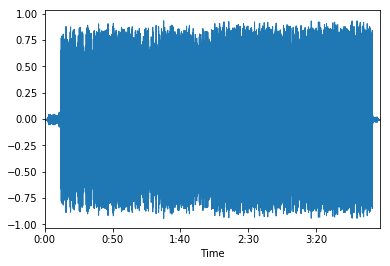

In [28]:
librosa.display.waveplot(y, sr=sr)

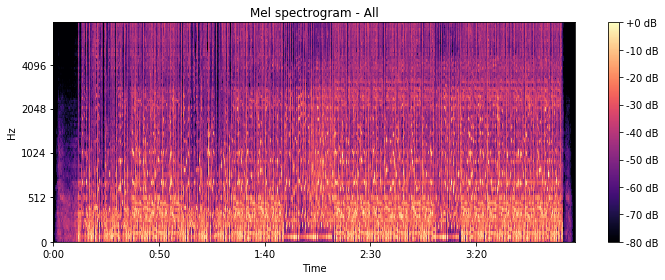

In [29]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram - All')
plt.tight_layout()
plt.show()

In [0]:
Audio(y, rate=sr)

### ボーカルのみ

In [0]:
in_path = input_mp3_filepath + "_vocals.wav"
y_vo, sr = librosa.core.load(in_path, mono=True)

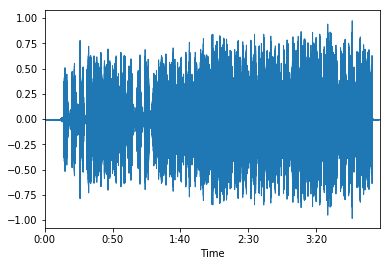

In [32]:
librosa.display.waveplot(y_vo, sr=sr)

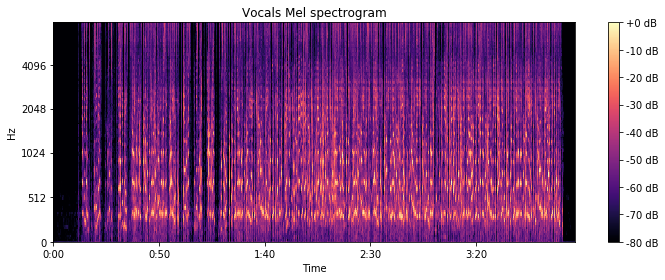

In [33]:
S = librosa.feature.melspectrogram(y=y_vo, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Vocals Mel spectrogram')
plt.tight_layout()
plt.show()

In [0]:
Audio(y_vo, rate=sr)

### 伴奏のみ

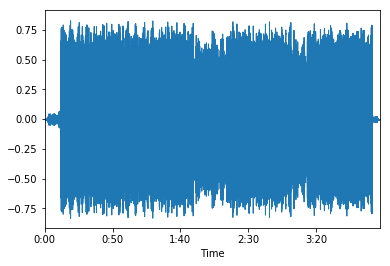

In [35]:
in_path = input_mp3_filepath + "_accompaniment.wav"
y_acc, sr = librosa.core.load(in_path, mono=True)
librosa.display.waveplot(y_acc, sr=sr)

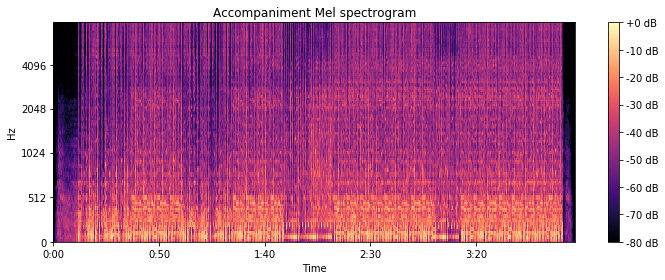

In [36]:
S = librosa.feature.melspectrogram(y=y_acc, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Accompaniment Mel spectrogram')
plt.tight_layout()
plt.show()

In [0]:
Audio(y_acc, rate=sr)